In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("global_aqi.csv")
print("Dataset shape:", df.shape)

Dataset shape: (20968, 4)


In [3]:
df = df.dropna(subset=["AQI Value"])
df = df.fillna(method="ffill")
print("After cleaning:", df.shape)

After cleaning: (20968, 4)


C:\Users\HP\AppData\Local\Temp\ipykernel_23852\3203348824.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


In [4]:
le_country = LabelEncoder()
le_status = LabelEncoder()


In [5]:
df["Country_encoded"] = le_country.fit_transform(df["Country"])
df["Status_encoded"] = le_status.fit_transform(df["Status"])

In [6]:
feature_cols = ["Country_encoded", "Status_encoded"]
for col in ["PM2.5", "PM10", "NO2", "SO2", "O3", "CO"]:
    if col in df.columns:
        feature_cols.append(col)

X = df[feature_cols]
y = df["AQI Value"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}
best_model = None
best_r2 = -np.inf

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MSE": mse, "MAE": mae, "R2": r2}
    print(f"{name} -> MSE={mse:.2f}, MAE={mae:.2f}, R2={r2:.3f}")

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_model_name = name
        best_predictions = y_pred


Linear Regression -> MSE=900.21, MAE=16.49, R2=0.614
Decision Tree -> MSE=190.94, MAE=9.06, R2=0.918
Random Forest -> MSE=188.00, MAE=9.04, R2=0.919
XGBoost -> MSE=192.37, MAE=9.50, R2=0.917


In [9]:
print("\n=== Model Comparison Results ===")
for name, scores in results.items():
    print(f"{name}: {scores}")


=== Model Comparison Results ===
Linear Regression: {'MSE': 900.2070783651354, 'MAE': 16.487719102027125, 'R2': 0.6138652112893827}
Decision Tree: {'MSE': 190.94185037363775, 'MAE': 9.058607979670418, 'R2': 0.9180974102270574}
Random Forest: {'MSE': 187.9969123568242, 'MAE': 9.03970869565601, 'R2': 0.9193606118239092}
XGBoost: {'MSE': 192.3724365234375, 'MAE': 9.49583625793457, 'R2': 0.9174838066101074}


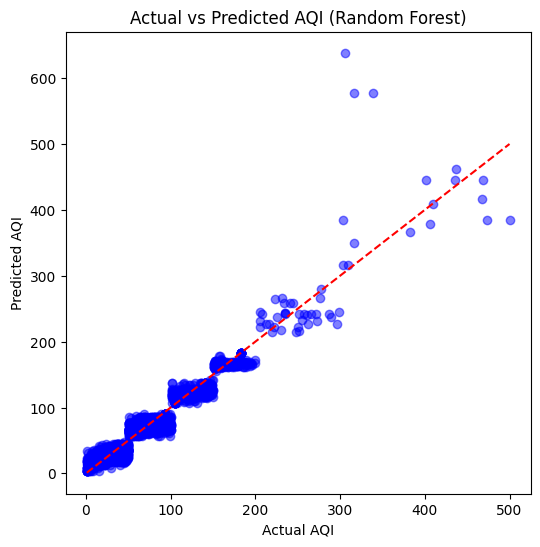

In [11]:
os.makedirs("models", exist_ok=True) 
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_predictions, alpha=0.5, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title(f"Actual vs Predicted AQI ({best_model_name})")
plt.savefig("models/actual_vs_predicted.png")
plt.show()